# 🌎 U-Net for Seismic Phase Picking

**Author:** Loïc Bachelot  
**Goal:** This notebook demonstrates how to define and train a U-Net model to detect seismic phases from waveform data.

---

## 📘 Overview

Seismologists often need to detect the arrival times of P and S waves in continuous waveform recordings. These arrival times are crucial for locating earthquakes and understanding subsurface structures.

In this notebook:
1. We define a U-Net architecture inspired by [PhaseNet](https://github.com/wayneweiqiang/PhaseNet), adapted for 1D waveform inputs.
2. The input is a windowed waveform.
3. The output is a probability distribution over time indicating the likelihood of P and S wave arrivals.
4. We visualize intermediate encoder/decoder outputs to understand how the network transforms the signal.

The focus is on interpretability and pedagogical clarity — ideal for first-time users of deep learning in seismology.


## Data Preparation
We load a minimal subset of data required for model training. Detailed dataset explanations are handled in a separate notebook.

In [1]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import seisbench.data as sbd
from torch.utils.data import random_split, DataLoader
import seisbench.generate as sbg
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Load the dataset from the current directory
data = sbd.WaveformDataset("/home/jovyan/shared/shortcourses/crescent_ml_2025/pnwml/mini/", component_order="ENZ")
print(data)

2025-05-09 17:32:00,457 | seisbench | WARNING | Dimension order not specified in data set. Assuming CW.


Unnamed dataset - 1720 traces


In [4]:
data._metadata = data.metadata[data.metadata.source_type == "earthquake"].reset_index(drop=True)
print(data)

Unnamed dataset - 500 traces


In [5]:
# In-place modification to add training, validation and testing split
np.random.seed(42)
indices = np.random.permutation(len(data.metadata))
n_total = len(data.metadata)
n_train = int(0.4 * n_total)
n_val = int(0.1 * n_total)

# Directly modify the existing dataframe
data.metadata.loc[indices[:n_train], "split"] = "train"
data.metadata.loc[indices[n_train:n_train + n_val], "split"] = "dev"
data.metadata.loc[indices[n_train + n_val:], "split"] = "test"

In [6]:
train = data.train()
val = data.dev()
test = data.test()
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}
model_labels = ["P", "S", "noise"]

train_generator = sbg.GenericGenerator(train)
val_generator = sbg.GenericGenerator(val)
test_generator = sbg.GenericGenerator(test)

# Define the augmentation pipeline used for training and validation
augmentations = [
    # Extract a window around a randomly chosen phase sample (P or S)
    sbg.WindowAroundSample(
        list(phase_dict.keys()), samples_before=3000, windowlen=6000,
        selection="random", strategy="variable"
    ),
    
    # If needed, randomly crop or pad the window to a fixed length
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    
    # Normalize waveform: remove mean and scale amplitude (peak normalization)
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    
    # Convert data type to float32 for training
    sbg.ChangeDtype(np.float32),
    
    # Convert phase pick times into soft labels using Gaussian curves
    sbg.ProbabilisticLabeller(label_columns=phase_dict, model_labels=model_labels, sigma=30, dim=0)
]

# Define a simpler augmentation for test data (no cropping or shifting)
test_augmentations = [
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, model_labels=model_labels, sigma=30, dim=0)
]

# Add augmentations to each dataset split
train_generator.add_augmentations(augmentations)
val_generator.add_augmentations(augmentations)
test_generator.add_augmentations(test_augmentations)

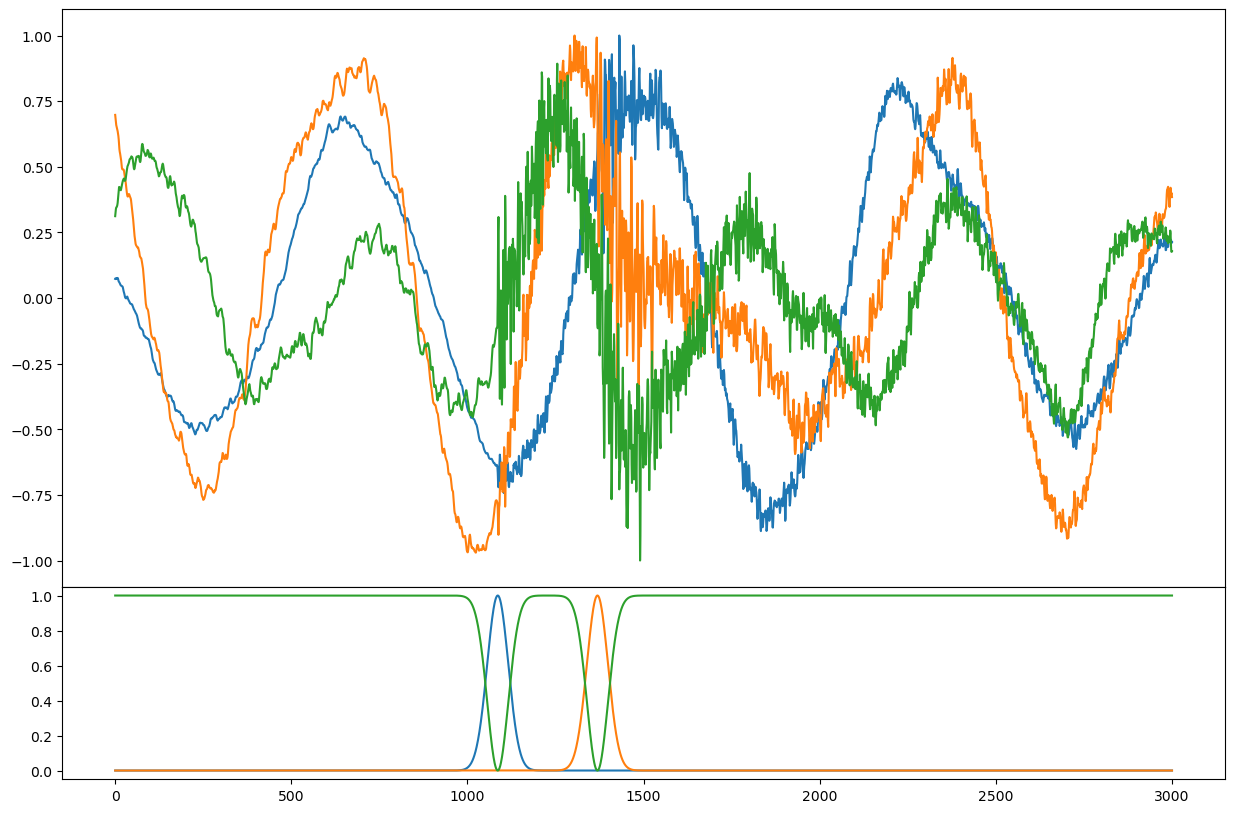

In [7]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

### Prepare data for pytorch

In [8]:
from seisbench.util import worker_seeding

batch_size = 256
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
val_loader = DataLoader(val_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

## U-Net Model Definition

In this section, we define a **U-Net** architecture tailored for 1D seismic waveform data. This model is inspired by [**PhaseNet**](https://doi.org/10.1093/gji/ggy423), a deep learning approach that demonstrated strong performance in seismic phase picking.

### 🧠 What is a U-Net?

A **U-Net** is a type of convolutional neural network originally developed for biomedical image segmentation. It has since proven effective for many tasks involving **dense predictions**, including segmentation and signal labeling. The U-Net architecture is characterized by:

- A **contracting path** (encoder) that captures context through convolution and downsampling,
- An **expanding path** (decoder) that enables precise localization by upsampling,
- **Skip connections** that bridge encoder and decoder layers at the same resolution, preserving high-resolution features.

Here's the architecture of **PhaseNet**, which adapts this idea for **1D seismic signals**:

![PhaseNet architecture](./phasenet.png)

> *Weiqiang Zhu & Gregory C. Beroza (2019), PhaseNet: a deep-neural-network-based seismic arrival-time picking method, GJI, [DOI:10.1093/gji/ggy423](https://doi.org/10.1093/gji/ggy423)*

### 🧭 Why use a U-Net for Seismology?

Seismic waveform analysis requires:
- **Context awareness** to detect arrival patterns over time,
- **Precise localization** of P and S phase arrivals,
- **Multiscale feature extraction**, since phase arrivals can vary in shape and amplitude.

A U-Net is especially suited for this because:
- The **encoder** captures long-range dependencies in the waveform,
- The **decoder** reconstructs fine-grained outputs (e.g., phase probability at each timestep),
- **Skip connections** ensure no loss of detail during downsampling.

This makes it a perfect fit for **dense, frame-by-frame classification** of seismic traces.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# Define the U-Net architecture
# Cell 2: U-Net Building Blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[16, 32, 64, 128]):
        super().__init__()
        
        self.downs = nn.ModuleList()  # Encoder blocks (downsampling path)
        self.ups = nn.ModuleList()    # Decoder blocks (upsampling path)
    
        # ----- Encoder: Downsampling Path -----
        # Each ConvBlock halves the temporal resolution via pooling (done in forward),
        # and increases the number of feature channels.
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))  # ConvBlock: Conv + ReLU + Conv + ReLU
            in_channels = feat  # Update in_channels for the next block
    
        # ----- Bottleneck -----
        # Deepest layer in the U-Net, connects encoder and decoder
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
    
        # ----- Decoder: Upsampling Path -----
        # Reverse features list for symmetrical decoder
        rev_feats = features[::-1]
        for feat in rev_feats:
            # First upsample (via transposed convolution)
            self.ups.append(
                nn.ConvTranspose1d(feat*2, feat, kernel_size=2, stride=2)
            )
            # Then apply ConvBlock: input has double channels due to skip connection
            self.ups.append(ConvBlock(feat*2, feat))
    
        # ----- Final Output Convolution -----
        # 1x1 convolution to map to desired output channels (e.g., P, S, noise)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool1d(x, kernel_size=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_conn = skip_connections[idx//2]
            if x.shape[-1] != skip_conn.shape[-1]:
                x = F.pad(x, (0, skip_conn.shape[-1] - x.shape[-1]))
            x = torch.cat((skip_conn, x), dim=1)
            x = self.ups[idx+1](x)
        x = self.final_conv(x)
        return F.softmax(x, dim=1)

    def forward_intermediate(self, x):
        """
        Forward pass that returns intermediate features from encoder, bottleneck, and decoder.
    
        Returns:
            dict of tensors: including skip layers, bottleneck, and decoder layers.
        """
        features = {"input": x}
        skip_connections = []
    
        # ----- Encoder -----
        for i, down in enumerate(self.downs):
            x = down(x)
            features[f"enc{i+1}"] = x  # Save encoder output
            skip_connections.append(x)
            x = F.max_pool1d(x, kernel_size=2)
    
        # ----- Bottleneck -----
        x = self.bottleneck(x)
        features["bottleneck"] = x
        skip_connections = skip_connections[::-1]
    
        # ----- Decoder -----
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # upsampling
            skip_conn = skip_connections[idx // 2]
    
            # Handle any size mismatch from pooling
            if x.shape[-1] != skip_conn.shape[-1]:
                x = F.pad(x, (0, skip_conn.shape[-1] - x.shape[-1]))
    
            x = torch.cat((skip_conn, x), dim=1)
            x = self.ups[idx + 1](x)  # convolution after concatenation
            features[f"dec{idx//2 + 1}"] = x
    
        # ----- Final Prediction -----
        x = self.final_conv(x)
        out = F.softmax(x, dim=1)
        features["output"] = out
        return features

## Model Training

This section covers two main components:

### 🛠️ Helper Functions
We define modular functions to handle training 

### 🔁 Training Loop
We then orchestrate the training process:
- Select device (CPU/GPU),
- Initialize model and optimizer,
- Define early stopping and checkpointing criteria,
- Track training and validation losses,
- Save the best model based on validation loss.

The training loop uses the helper functions to process the data over multiple epochs, evaluate progress, and stop early if performance plateaus.


In [11]:
import numpy as np
import time
from tqdm import tqdm
from torchinfo import summary

In [12]:
# Training loop
def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

In [13]:
# Training loop
class EarlyStopper:
    """
    A class for early stopping the training process when the validation loss stops improving.

    Parameters:
    -----------
    patience : int, optional (default=1)
        The number of epochs with no improvement in validation loss after which training will be stopped.
    min_delta : float, optional (default=0)
        The minimum change in the validation loss required to qualify as an improvement.
    """

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        """
        Check if the training process should be stopped.

        Parameters:
        -----------
        validation_loss : float
            The current validation loss.

        Returns:
        --------
        stop : bool
            Whether the training process should be stopped or not.
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Training and Evaluation Helpers

To keep the training loop clean and modular, we define two helper functions:

- `train_loop(...)`: Trains the model for one epoch using a given dataset and optimizer.
- `test_loop(...)`: Evaluates the model on a validation or test set.

This separation improves **code readability**, helps **avoid repetition**, and makes the notebook easier to maintain or adapt later (e.g., for different models or datasets).

In [14]:
def train_loop(model, dataloader, optimizer, debug=False):
    """
    One epoch of training.

    Args:
        model (torch.nn.Module): The model to train.
        dataloader (DataLoader): Batches of training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.

    Returns:
        float: Average loss over the epoch.
    """
    mean_loss = 0
    total_samples = 0
    model.train()  # Set model to training mode
    size = len(dataloader.dataset)

    for batch_id, batch in enumerate(dataloader):
        # Forward pass — model prediction
        pred = model(batch["X"].to(device))

        # Compute the loss between prediction and ground truth
        loss = loss_fn(pred, batch["y"].to(device))
        mean_loss += loss * batch["X"].shape[0]  # scale back up by batch size
        total_samples += batch["X"].shape[0]

        # Backward pass and optimizer update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging every 5 batches
        if batch_id % 5 == 0:
            loss_val = loss.item()
            current = batch_id * batch["X"].shape[0]
            if debug:
                print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

    return mean_loss / size  # Return average loss for the epoch


def test_loop(model, dataloader):
    """
    Evaluation on validation or test data.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (DataLoader): Batches of data.

    Returns:
        float: Average loss over the dataset (per sample).
    """
    model.eval()
    test_loss = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(device))

            loss = loss_fn(pred, batch["y"].to(device)).item()
            test_loss += loss * batch["X"].shape[0]  # scale back up by batch size
            total_samples += batch["X"].shape[0]

    return test_loss / total_samples

## Training Configuration

Before training, we configure the computing device, model, optimizer, loss tracking, early stopping, and checkpointing.

- **Device selection** ensures training runs on GPU if available.
- **Model initialization** moves the model to the selected device.
- **Adam optimizer** is commonly used for deep learning due to adaptive learning rates.
- **Checkpointing** allows saving the best model during training.
- **Early stopping** halts training when the validation loss stops improving to prevent overfitting.
- **Logging** prints progress and training setup details for transparency and reproducibility.

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device {device}")
model = UNet1D().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
nb_epoch = 100
loss_train = []
loss_val = []
best_loss = 100 # init at something super high so 1st eval is best
best_epoch = 0
early_stopper = EarlyStopper(patience=3, min_delta=0.0)
model_name = "phasenet_style"
PATH_CHECKPOINT = f"./checkpoint/{model_name}.pt"
# Create the folder if it doesn't exist
os.makedirs(os.path.dirname(PATH_CHECKPOINT), exist_ok=True)
log_counter = 1

print("\n=== Training Configuration Recap ===")
print(f"Device: {device}")
print(f"Model: {model_name}")
print(f"Checkpoint Path: {PATH_CHECKPOINT}")
print(f"Optimizer: Adam")
print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"Epochs: {nb_epoch}")
print(f"Early Stopping Patience: {early_stopper.patience}")
print(f"Early Stopping Min Delta: {early_stopper.min_delta}")
print("====================================\n")
summary(model, input_size=(1, 3, 3001))

device cpu

=== Training Configuration Recap ===
Device: cpu
Model: phasenet_style
Checkpoint Path: ./checkpoint/phasenet_style.pt
Optimizer: Adam
Learning Rate: 0.001
Epochs: 100
Early Stopping Patience: 3
Early Stopping Min Delta: 0.0



Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 3, 3001]              --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 16, 3001]             --
│    │    └─Sequential: 3-1              [1, 16, 3001]             944
│    └─ConvBlock: 2-2                    [1, 32, 1500]             --
│    │    └─Sequential: 3-2              [1, 32, 1500]             4,672
│    └─ConvBlock: 2-3                    [1, 64, 750]              --
│    │    └─Sequential: 3-3              [1, 64, 750]              18,560
│    └─ConvBlock: 2-4                    [1, 128, 375]             --
│    │    └─Sequential: 3-4              [1, 128, 375]             73,984
├─ConvBlock: 1-2                         [1, 256, 187]             --
│    └─Sequential: 2-5                   [1, 256, 187]             --
│    │    └─Conv1d: 3-5                  [1, 256, 187]             98,560

## Training Loop

The model is trained using a typical PyTorch training loop with the following components:

- **Training and validation loss tracking**: The model is evaluated on both the training and validation set each epoch.
- **Checkpointing**: The best model (with lowest validation loss) is saved automatically.
- **Early stopping**: Training stops if the validation loss doesn't improve for a preset number of epochs, helping to avoid overfitting.
- **Logging**: Progress is logged every few epochs, including the current and best losses and timing information.

This setup ensures that the model is both efficient and robust during training.


In [16]:
# Training loop with early stopping and checkpointing

start_time = time.perf_counter()
print(f"Training starting — number of epochs = {nb_epoch}")

for epoch in range(nb_epoch):
    # Train on one epoch and record the training loss
    loss_train.append(train_loop(model, train_loader, optimizer))
    
    # Evaluate on validation set and record the loss
    loss_val.append(test_loop(model, val_loader))
    
    # If validation loss improves, save the model checkpoint
    if loss_val[-1] < best_loss:
        best_loss = loss_val[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), PATH_CHECKPOINT)  # Save best model

    # Check early stopping condition (e.g., no improvement for N epochs)
    if early_stopper.early_stop(loss_val[-1]):
        print(f"Early stopping at epoch {epoch}:")
        print(f"  → Train loss = {loss_train[-1]:.6f}")
        print(f"  → Val loss   = {loss_val[-1]:.6f}")
        break

    # Logging every `log_counter` epochs
    if epoch % log_counter == 0:
        print(f"Epoch {epoch}:")
        print(f"  → Train loss = {loss_train[-1]:.6f}")
        print(f"  → Val loss   = {loss_val[-1]:.6f}")
        print(f"  → Best val loss = {best_loss:.6f} (epoch {best_epoch})")
        print(f"  → Avg time per epoch = {(time.perf_counter() - start_time) / log_counter:.2f} sec")
        print("\n#####################\n")
        start_time = time.perf_counter()

Training starting — number of epochs = 100
Epoch 0:
  → Train loss = 1.102228
  → Val loss   = 1.093189
  → Best val loss = 1.093189 (epoch 0)
  → Avg time per epoch = 10.11 sec

#####################

Epoch 1:
  → Train loss = 1.093023
  → Val loss   = 1.084363
  → Best val loss = 1.084363 (epoch 1)
  → Avg time per epoch = 7.62 sec

#####################

Epoch 2:
  → Train loss = 1.084411
  → Val loss   = 1.076120
  → Best val loss = 1.076120 (epoch 2)
  → Avg time per epoch = 7.63 sec

#####################

Epoch 3:
  → Train loss = 1.076106
  → Val loss   = 1.067989
  → Best val loss = 1.067989 (epoch 3)
  → Avg time per epoch = 7.75 sec

#####################

Epoch 4:
  → Train loss = 1.067736
  → Val loss   = 1.059975
  → Best val loss = 1.059975 (epoch 4)
  → Avg time per epoch = 7.80 sec

#####################

Epoch 5:
  → Train loss = 1.059910
  → Val loss   = 1.053105
  → Best val loss = 1.053105 (epoch 5)
  → Avg time per epoch = 7.94 sec

#####################

Epoch 6:

In [17]:
# Training loop
print(f"training finished, restoring best weights")
model.load_state_dict(torch.load(PATH_CHECKPOINT, map_location=device))
print(f"best loss={best_loss}, model eval loss={test_loop(model, val_loader)} at epoch {best_epoch}")

training finished, restoring best weights
best loss=0.24829817415755306, model eval loss=0.24385667661295393 at epoch 17


#### For time saving, loading pretrained model  
I pretrained the same UNet on the full PNW dataset, we use this pretrained version here for evaluation

In [18]:
# Load previous full training
model.load_state_dict(torch.load("./model_weights_eq_only.pt", map_location=device))

<All keys matched successfully>

## Inference on Long Waveforms

After training, we want to apply the model to long, continuous waveform data.

Because the U-Net expects fixed-length input (e.g., 3001 samples), we use **sliding window inference** to break long waveforms into overlapping chunks, apply the model to each chunk, and then combine the outputs.

Key steps:
- `extract_sliding_windows(...)`: slices the waveform into overlapping windows.
- `batched_sliding_inference(...)`: runs the model on all windows efficiently using batching, then recombines predictions.
- `normalize_waveform(...)`: standard preprocessing to center and scale amplitude.

This allows us to make **dense predictions** over time (e.g., probability of P or S arrivals at each time step) even on long signals.


In [19]:
def extract_sliding_windows(waveform, window_size=3001, stride=10):
    """
    Slice the waveform into overlapping sliding windows.

    Args:
        waveform (np.ndarray): Array of shape (3, T) — 3 channels (Z, N, E).
        window_size (int): Length of each window.
        stride (int): Step size between windows.

    Returns:
        windows (np.ndarray): Shape (num_windows, 3, window_size)
        indices (np.ndarray): Starting indices of each window
    """
    C, T = waveform.shape
    indices = np.arange(0, T - window_size + 1, stride)
    windows = np.stack([waveform[:, i:i + window_size] for i in indices], axis=0)
    return windows, indices


def batched_sliding_inference(waveform, model, window_size=3001, stride=100, device="cpu", batch_size=512):
    """
    Perform model inference over a long waveform using overlapping sliding windows.

    Args:
        waveform (np.ndarray): Shape (3, T), raw waveform data.
        model (torch.nn.Module): Trained model.
        window_size (int): Length of each input window.
        stride (int): Step between windows.
        device (str): 'cpu' or 'cuda'.
        batch_size (int): Number of windows per batch.

    Returns:
        probs (np.ndarray): Shape (3, T), class probabilities for each timestep.
    """
    model.eval()
    waveform = waveform.astype(np.float32)
    
    # Split waveform into overlapping windows
    windows, indices = extract_sliding_windows(waveform, window_size, stride)
    num_windows = len(windows)

    # Initialize prediction buffer and count buffer
    probs = np.zeros((3, waveform.shape[1]))
    counts = np.zeros((waveform.shape[1],))

    # Run model in batches over windows
    for i in range(0, num_windows, batch_size):
        batch = torch.tensor(windows[i:i + batch_size], dtype=torch.float32).to(device)
        with torch.no_grad():
            out = model(batch).cpu().numpy()  # shape: (B, 3, window_size)

        # Aggregate overlapping predictions
        for j, idx in enumerate(indices[i:i + batch_size]):
            probs[:, idx:idx + window_size] += out[j]
            counts[idx:idx + window_size] += 1

    # Normalize by number of overlapping windows at each time step
    counts[counts == 0] = 1  # avoid division by zero
    probs /= counts

    return probs


def normalize_waveform(waveform):
    """
    Normalize waveform: zero-mean and peak amplitude scaling.

    Args:
        waveform (np.ndarray): Shape (3, T), raw waveform.

    Returns:
        np.ndarray: Normalized waveform of same shape.
    """
    waveform = waveform - np.mean(waveform, axis=-1, keepdims=True)
    norm = np.max(np.abs(waveform), axis=-1, keepdims=True)
    norm[norm == 0] = 1  # avoid division by zero
    return waveform / norm

## Running Inference on Test Set

We now evaluate the model on a set of test waveforms using the `batched_sliding_inference(...)` method defined earlier.

Each waveform is:
- **Normalized** using peak amplitude scaling,
- **Processed in overlapping windows** by the model,
- **Reconstructed into a full-length probability prediction**.

We also collect metadata such as true labels and arrival times for later comparison and visualization.


In [20]:
all_results = []
number_samples = 20
# Loop over number_samples test samples
for i in tqdm(range(number_samples)):
    # Use test_generator to get the full sample, including labels
    sample = test_generator[i]
    
    # Extract waveform, true soft labels, and metadata
    waveform = sample["X"]  # Shape: (3, T)
    true_labels = sample["y"]  # Shape: (3, T), soft targets for P/S/Noise
    meta = sample.get("meta", test.get_sample(i)[1])  # Fall back to original metadata if needed

    # Normalize waveform before feeding to model
    waveform = normalize_waveform(waveform.astype(np.float32))

    # Run sliding window inference on the waveform
    start = time.time()
    pred = batched_sliding_inference(waveform, model, device=device)
    end = time.time()

    # Collect results in a dictionary
    all_results.append({
        "trace_id": meta.get("trace_name", f"trace_{i}"),
        "waveform": waveform,
        "true_labels": true_labels,
        "prediction": pred,
        "p_arrival": meta.get("trace_P_arrival_sample"),
        "s_arrival": meta.get("trace_S_arrival_sample"),
        "meta": meta,
        "inference_time": end - start
    })

print(f"Inference finished for the {number_samples} test samples")

100%|██████████| 20/20 [00:18<00:00,  1.06it/s]

Inference finished for the 20 test samples


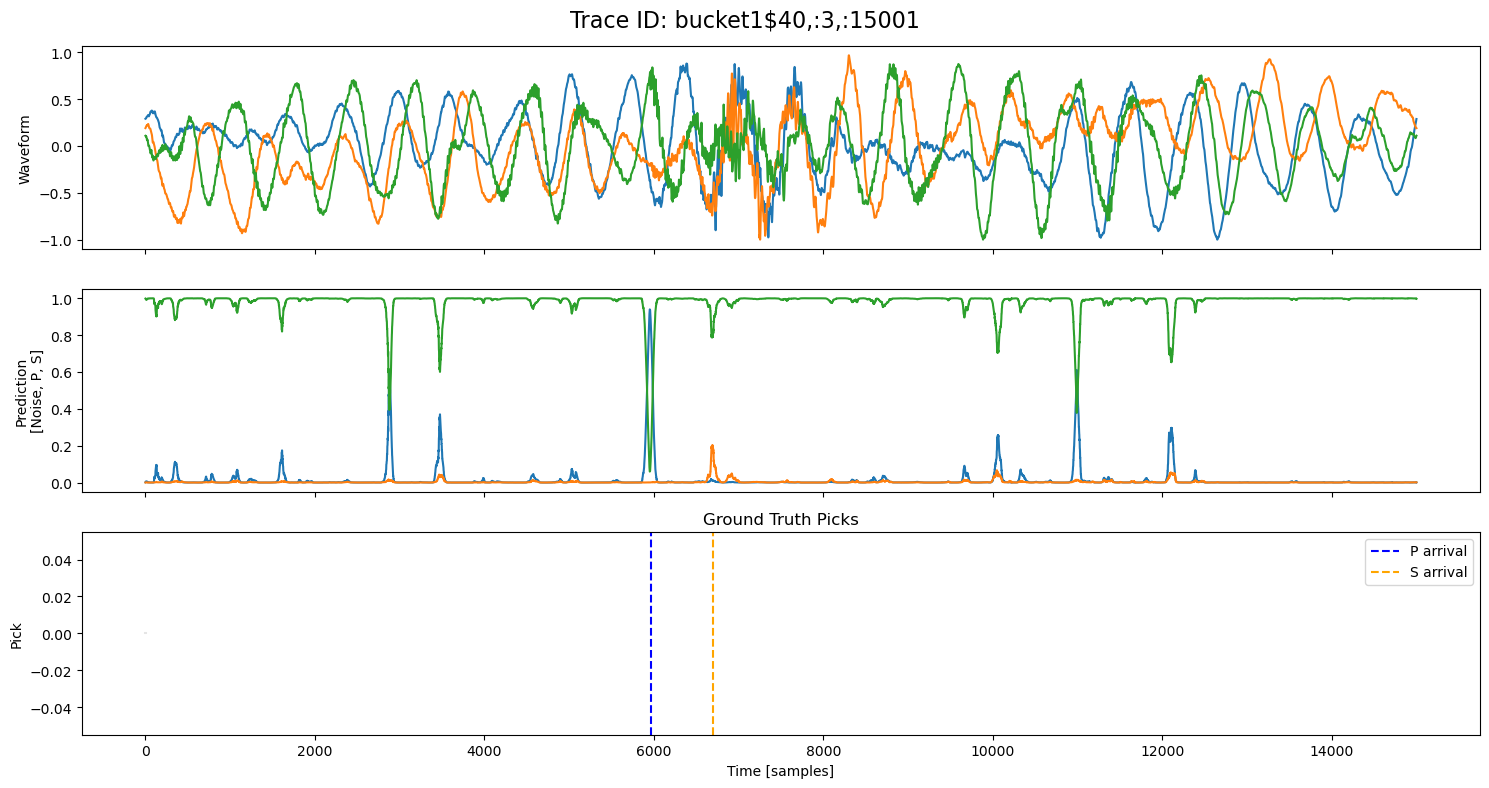

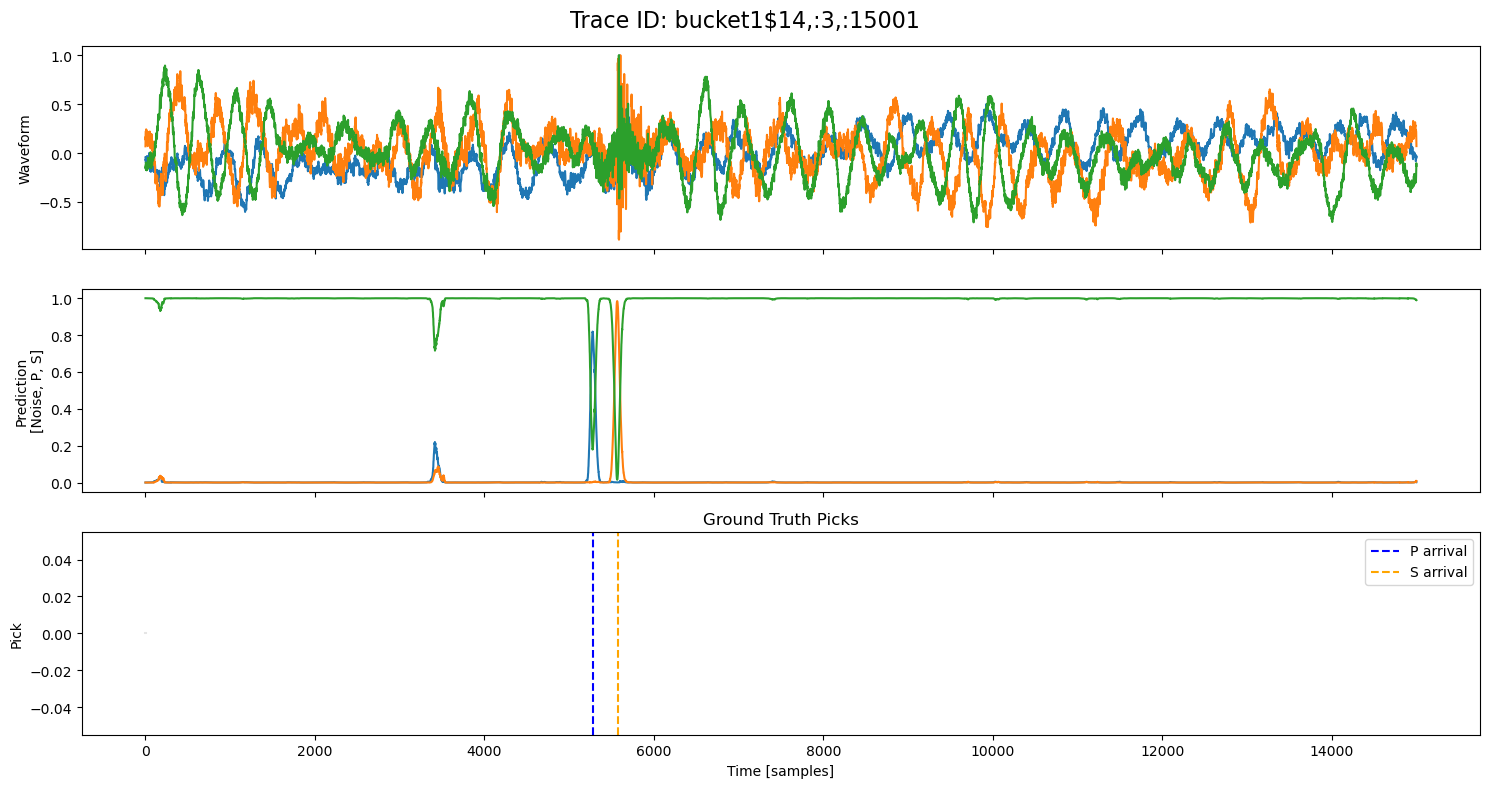

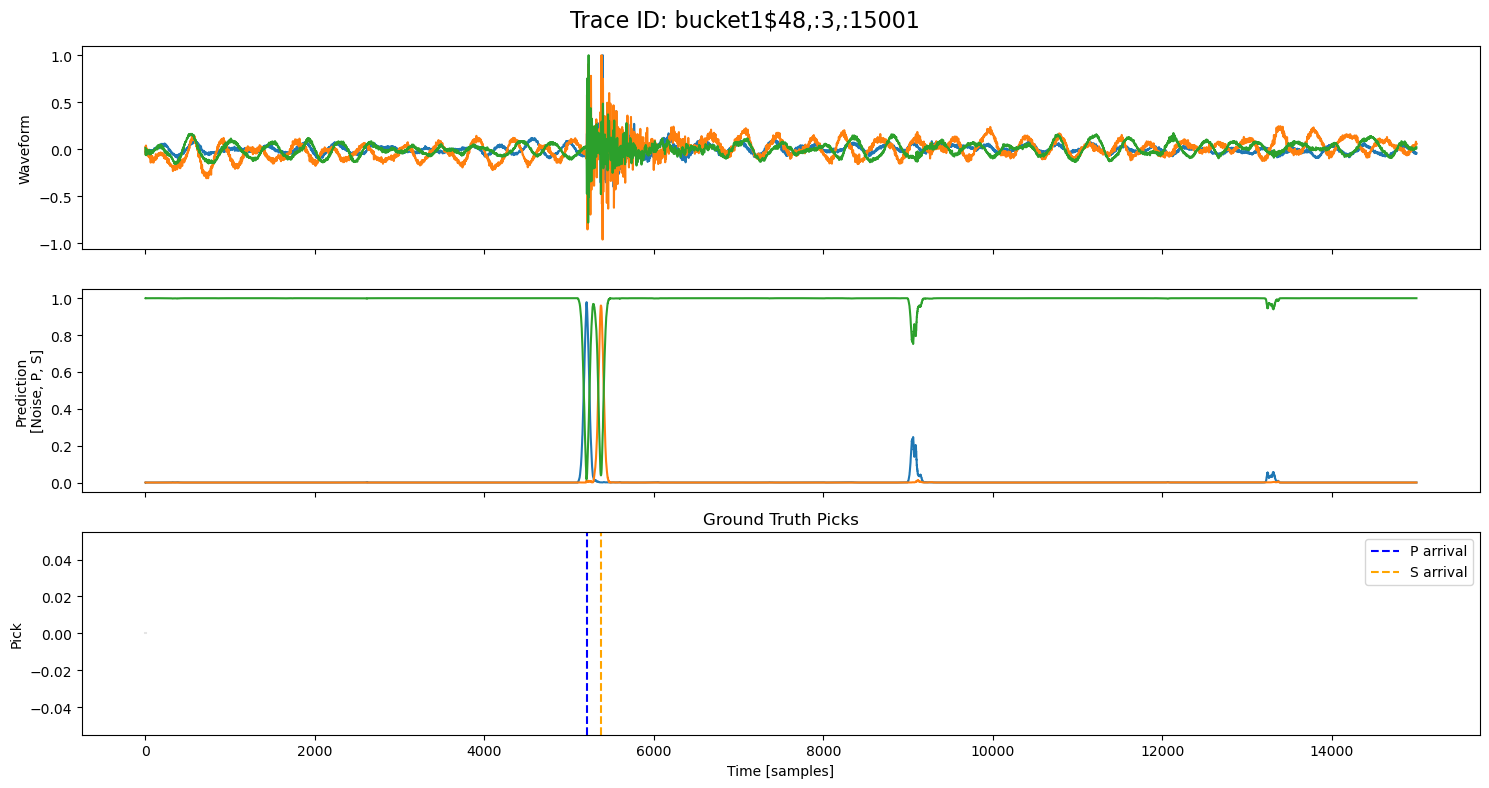

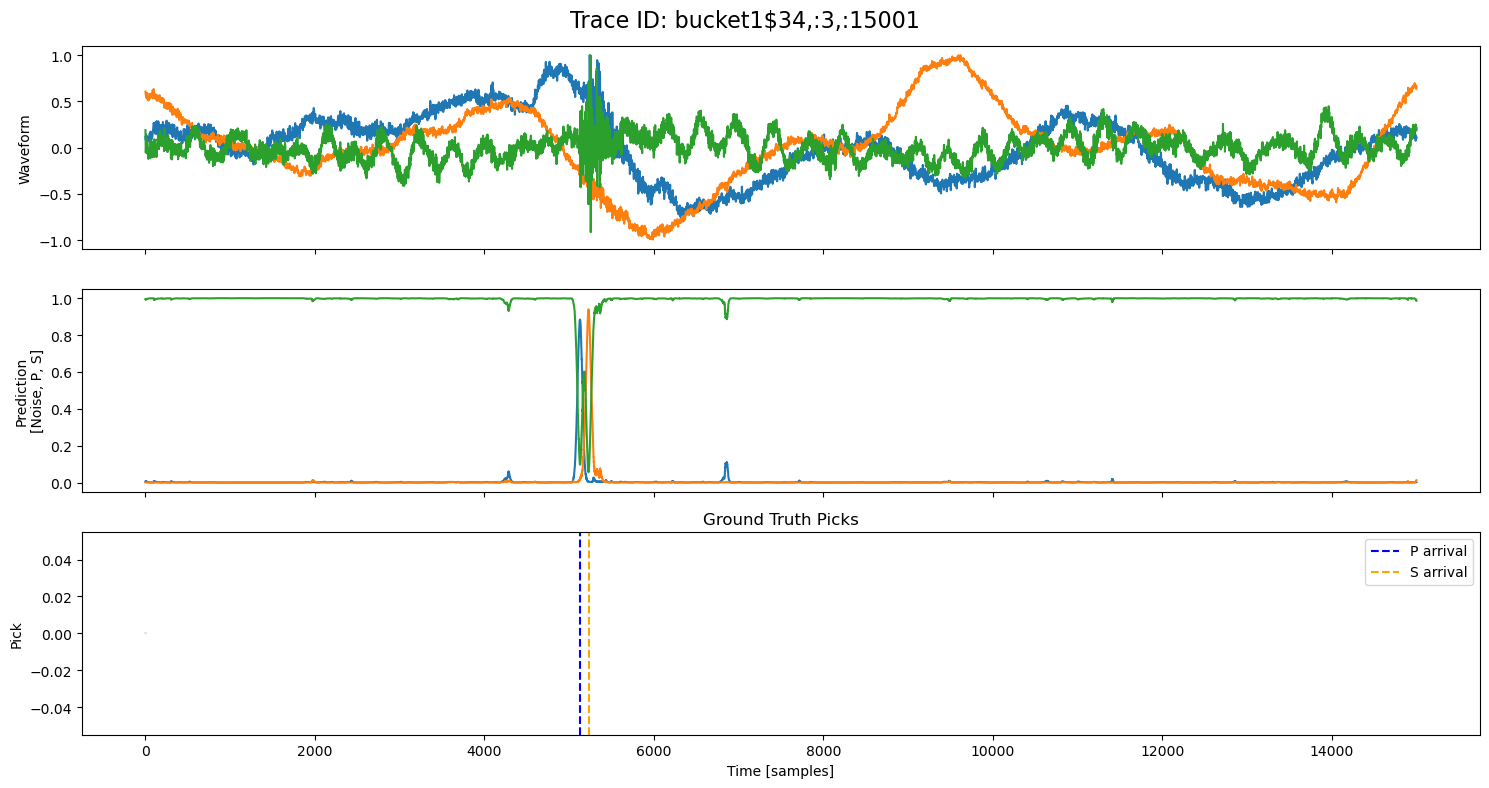

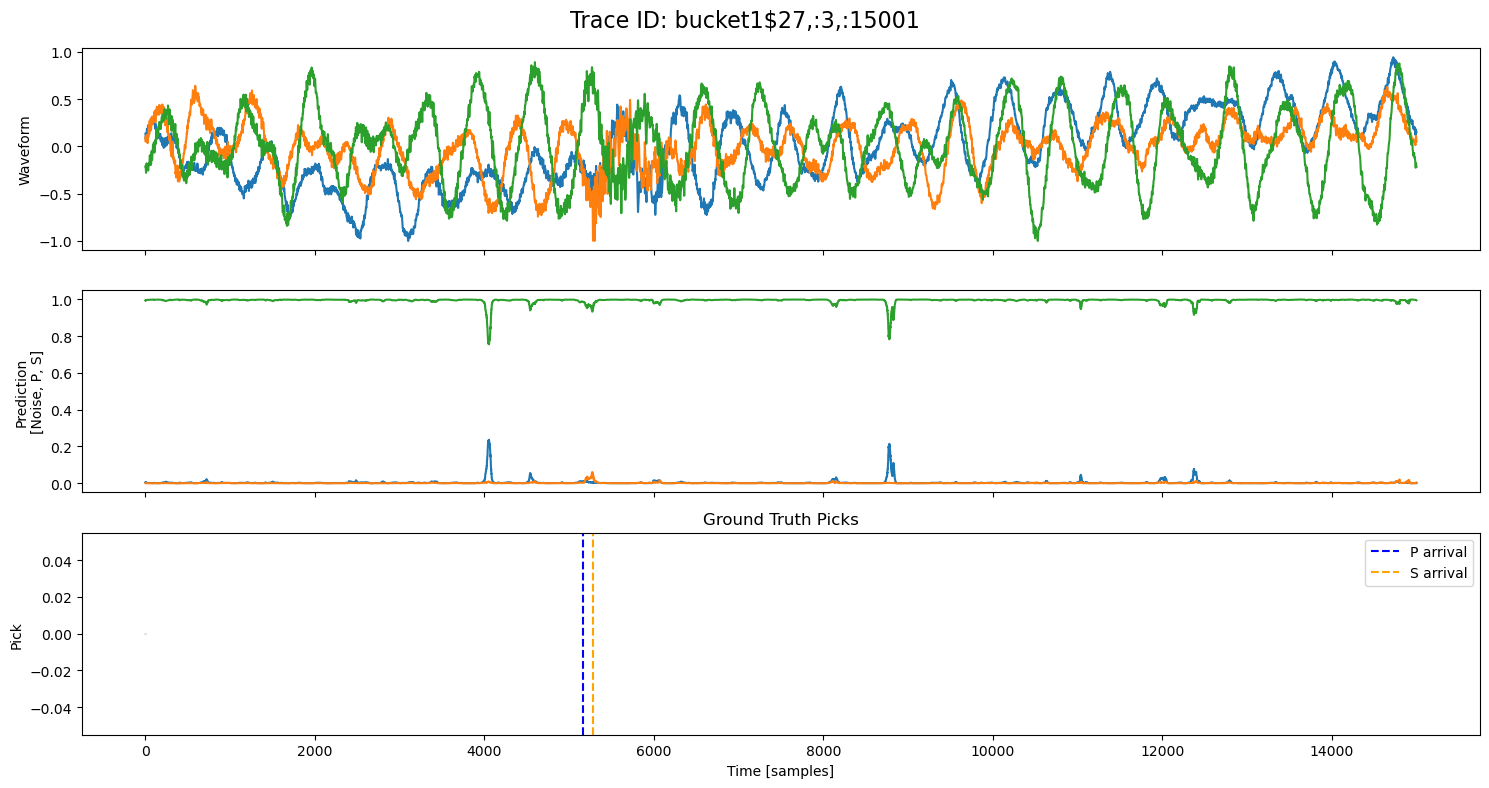

In [21]:
examples = np.random.choice(all_results, 5, replace=False)

for example in examples:
    fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
    fig.suptitle(f"Trace ID: {example['trace_id']}", fontsize=16)

    waveform = example["waveform"]
    pred = example["prediction"]

    axs[0].plot(waveform.T)
    axs[0].set_ylabel("Waveform")

    axs[1].plot(pred.T)
    axs[1].set_ylabel("Prediction\n[Noise, P, S]")

    axs[2].set_title("Ground Truth Picks")
    axs[2].plot(pred.T[0]*0, "gray", alpha=0.2)  # zero baseline

    if example["p_arrival"] is not None:
        axs[2].axvline(example["p_arrival"], color="blue", linestyle="--", label="P arrival")
    if example["s_arrival"] is not None:
        axs[2].axvline(example["s_arrival"], color="orange", linestyle="--", label="S arrival")
    
    axs[2].legend()
    axs[2].set_xlabel("Time [samples]")
    axs[2].set_ylabel("Pick")

    plt.tight_layout()
    plt.show()

## 🔍 Explore Encoded Layers (Windowed)

To gain insight into what the U-Net is learning internally, we extract a 3001-sample window from a test waveform that includes P and S arrivals.

We examine:
- The original 3-channel waveform (Z, N, E),
- The deepest bottleneck representation,
- The final output probabilities for P, S, and Noise.

We overlay the P and S arrival times across all plots to highlight how seismic phase information propagates through the network’s hierarchy.

### Visualizing Model Inference and Intermediate Features

In this section, we extract a test window from the waveform that includes both P and S arrivals. We run the trained U-Net model on this window and visualize:

1. **Input waveform**: Three channels (Z, N, E) with amplitude offset for clarity.
2. **Bottleneck features**: A heatmap showing the compressed feature representation after the encoder.
3. **Predictions vs. True Labels**: Model output probabilities for P, S, and Noise classes compared against the ground truth.

Red and green vertical lines mark the P and S arrival times, respectively, allowing for visual evaluation of model accuracy.

This type of visualization helps understand how the model transforms seismic data at different stages and assess the quality of its predictions.

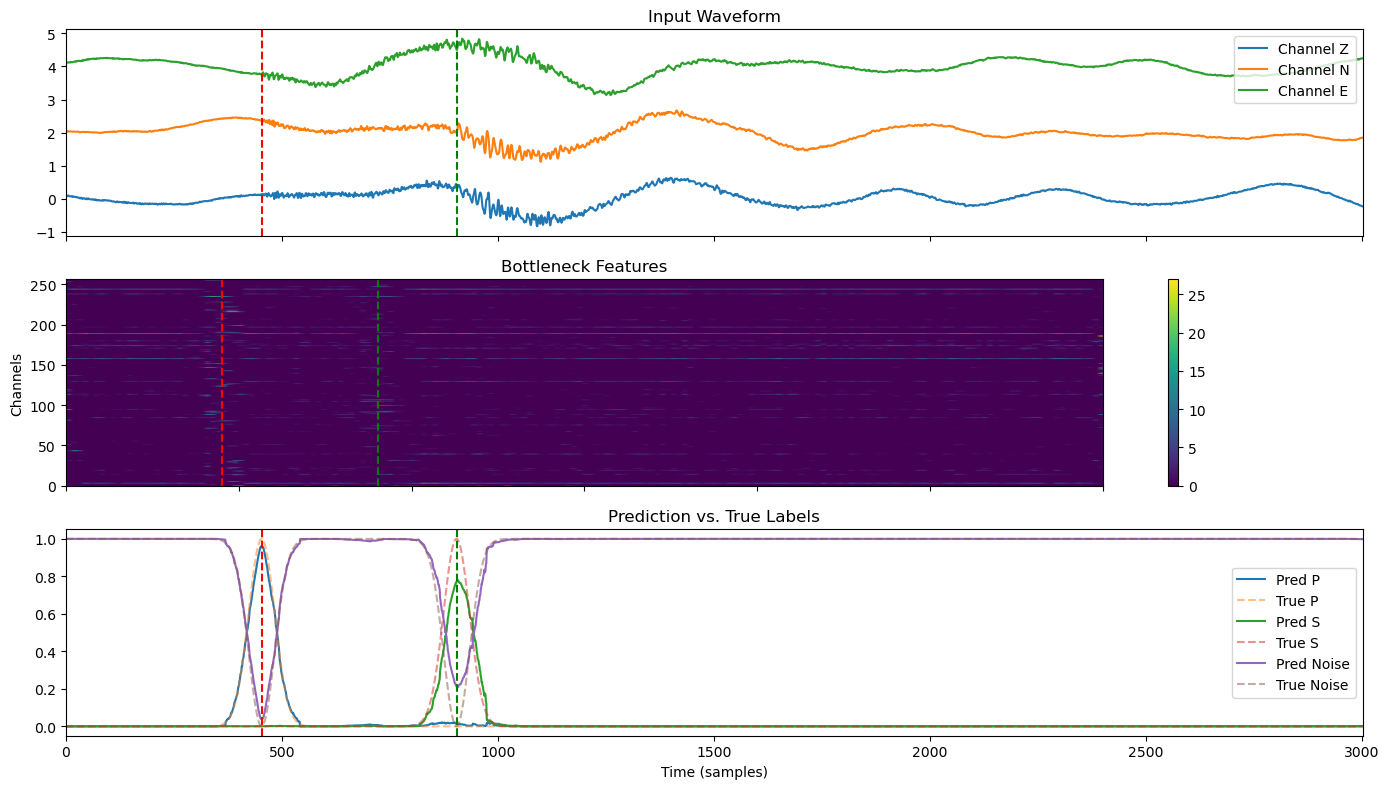

In [22]:
# --- 1. Slice a test window that includes P and S arrivals ---
start = 5000  # start index of the window
window_len = 3001
sample_id = 12
sample = test_generator[sample_id]
waveform = sample["X"][:, start:start+window_len]
true_labels = sample["y"][:, start:start+window_len]
meta = sample.get("meta", test.get_sample(sample_id)[1])  # get metadata

x = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).to(device)

# --- 2. Run model with intermediate outputs ---
features = model.forward_intermediate(x)
input_wave = features["input"].squeeze().cpu().detach().numpy()
bottleneck = features["bottleneck"].squeeze().cpu().detach().numpy()
prediction = features["output"].squeeze().cpu().detach().numpy()

# --- 3. Setup figure ---
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

# --- 4. Plot input waveform ---
for i in range(3):
    axes[0].plot(input_wave[i] + i * 2, label=f"Channel {['Z', 'N', 'E'][i]}")
axes[0].set_title("Input Waveform")
axes[0].legend()

# --- 5. Plot bottleneck features as heatmap with extended x-axis ---
input_len = input_wave.shape[-1]
extent = [0, input_len, 0, bottleneck.shape[0]]
im = axes[1].imshow(bottleneck, aspect="auto", cmap="viridis", extent=extent)
axes[1].set_title("Bottleneck Features")
axes[1].set_ylabel("Channels")
plt.colorbar(im, ax=axes[1], orientation="vertical")

# --- 6. Plot predictions vs. true labels ---
labels = ["P", "S", "Noise"]
for i in range(3):
    axes[2].plot(prediction[i], label=f"Pred {labels[i]}", linestyle='-')
    axes[2].plot(true_labels[i], label=f"True {labels[i]}", linestyle='--', alpha=0.5)
axes[2].set_title("Prediction vs. True Labels")
axes[2].legend()
axes[2].set_xlabel("Time (samples)")

# --- 7. Overlay P and S arrival lines (aligned with input time) ---
p_arrival = meta.get("trace_P_arrival_sample")
s_arrival = meta.get("trace_S_arrival_sample")

if p_arrival is not None:
    p_shifted = p_arrival - start
    if 0 <= p_shifted < input_len:
        for ax in axes:
            ax.axvline(p_shifted, color="red", linestyle="--", label="P arrival")
if s_arrival is not None:
    s_shifted = s_arrival - start
    if 0 <= s_shifted < input_len:
        for ax in axes:
            ax.axvline(s_shifted, color="green", linestyle="--", label="S arrival")

plt.tight_layout()
plt.show()

## Comparing Early and Late Layers

To better understand how the U-Net transforms seismic signals, we visualize:

- The original input waveform,
- The **first encoder layer output** (early, low-level features),
- The **last decoder layer output** (just before final prediction),
- The final prediction probabilities vs. true labels.

We overlay the P and S arrival times to show how signal structures evolve through the network while still preserving alignment with the seismic event.

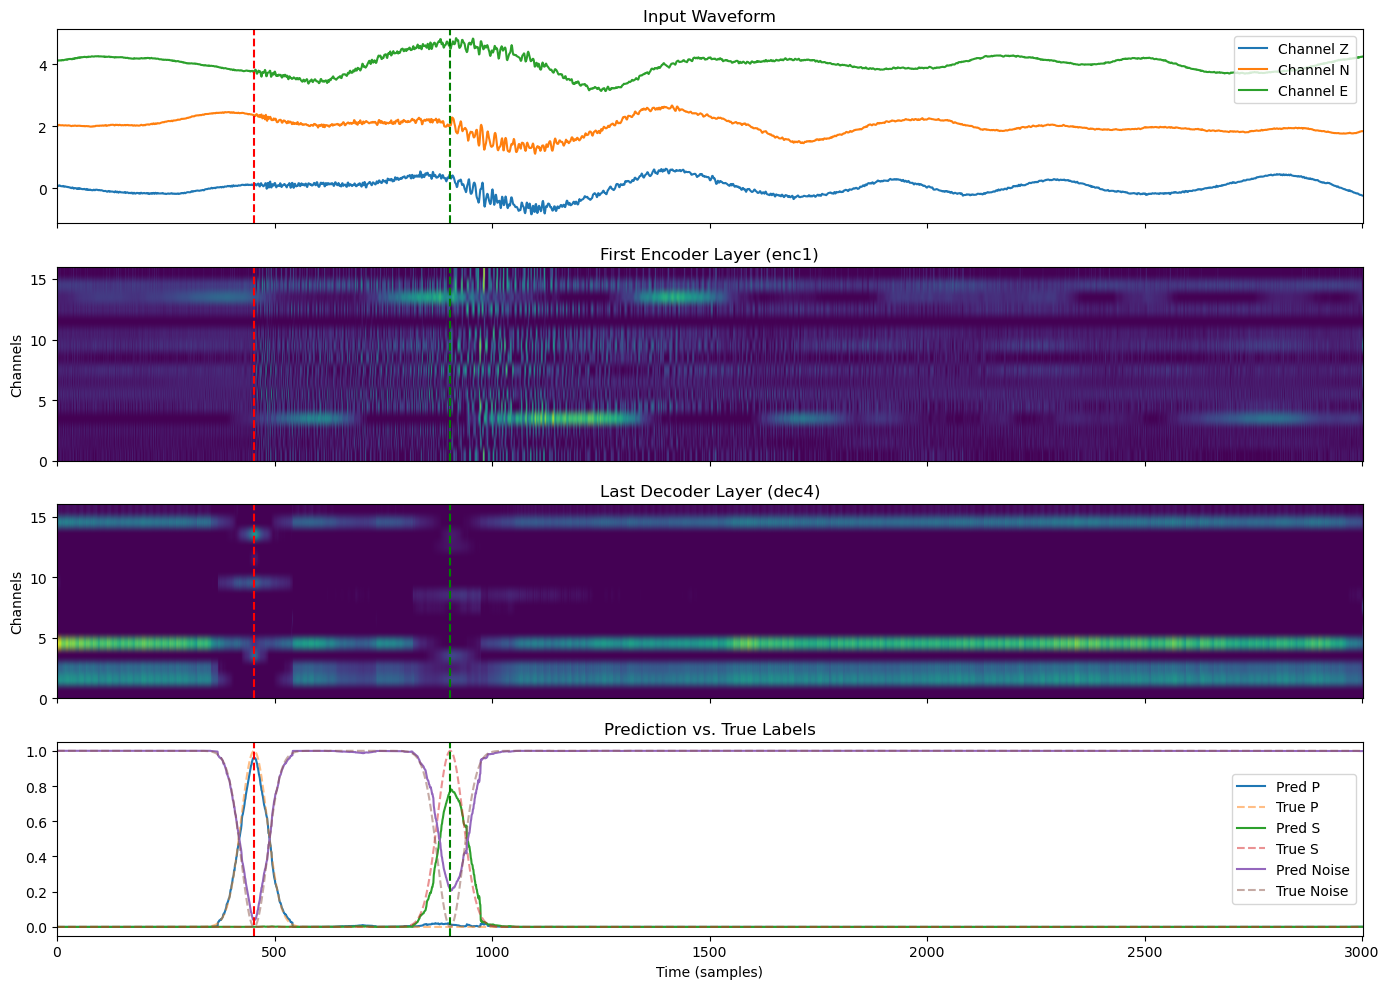

In [23]:
# --- 1. Slice a test window that includes P and S arrivals ---
start = 5000  # start index of the window
window_len = 3001
sample_id = 12
sample = test_generator[sample_id]
waveform = sample["X"][:, start:start+window_len]
true_labels = sample["y"][:, start:start+window_len]
meta = sample.get("meta", test.get_sample(sample_id)[1])  # get metadata

x = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).to(device)

# --- 2. Run model and extract intermediate features ---
features = model.forward_intermediate(x)
input_wave = features["input"].squeeze().cpu().detach().numpy()
enc1 = features["enc1"].squeeze().cpu().detach().numpy()
bottleneck = features["bottleneck"].squeeze().cpu().detach().numpy()
dec_last = features["dec4"].squeeze().cpu().detach().numpy()
prediction = features["output"].squeeze().cpu().detach().numpy()

# --- 3. Plot input, enc1, dec_last, and output ---
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Plot input waveform
for i in range(3):
    axes[0].plot(input_wave[i] + i * 2, label=f"Channel {['Z', 'N', 'E'][i]}")
axes[0].set_title("Input Waveform")
axes[0].legend()

# Plot encoder layer 1
axes[1].imshow(enc1, aspect="auto", cmap="viridis", extent=[0, input_wave.shape[-1], 0, enc1.shape[0]])
axes[1].set_title("First Encoder Layer (enc1)")
axes[1].set_ylabel("Channels")

# Plot last decoder layer
axes[2].imshow(dec_last, aspect="auto", cmap="viridis", extent=[0, input_wave.shape[-1], 0, dec_last.shape[0]])
axes[2].set_title("Last Decoder Layer (dec4)")
axes[2].set_ylabel("Channels")

# Plot predictions vs true labels
labels = ["P", "S", "Noise"]
for i in range(3):
    axes[3].plot(prediction[i], label=f"Pred {labels[i]}", linestyle='-')
    axes[3].plot(true_labels[i], label=f"True {labels[i]}", linestyle='--', alpha=0.5)
axes[3].set_title("Prediction vs. True Labels")
axes[3].legend()
axes[3].set_xlabel("Time (samples)")

# --- 4. Add vertical lines for P and S arrivals if within window ---
p_arrival = meta.get("trace_P_arrival_sample")
s_arrival = meta.get("trace_S_arrival_sample")

if p_arrival is not None:
    p_shifted = p_arrival - start
    if 0 <= p_shifted < input_wave.shape[-1]:
        for ax in axes:
            ax.axvline(p_shifted, color="red", linestyle="--", label="P arrival")

if s_arrival is not None:
    s_shifted = s_arrival - start
    if 0 <= s_shifted < input_wave.shape[-1]:
        for ax in axes:
            ax.axvline(s_shifted, color="green", linestyle="--", label="S arrival")

plt.tight_layout()
plt.show()

## Layer-by-Layer Feature Evolution

In this plot, we visualize the full feature transformation pipeline through the U-Net:

1. The original input waveform (Z/N/E channels),
2. Each intermediate layer (encoder stages, bottleneck, decoder stages),
3. The final prediction compared to the true soft labels.

All layers are plotted on the same time axis and overlaid with P and S wave arrival times. This view illustrates how temporal patterns are captured, abstracted, and reconstructed across the network hierarchy.

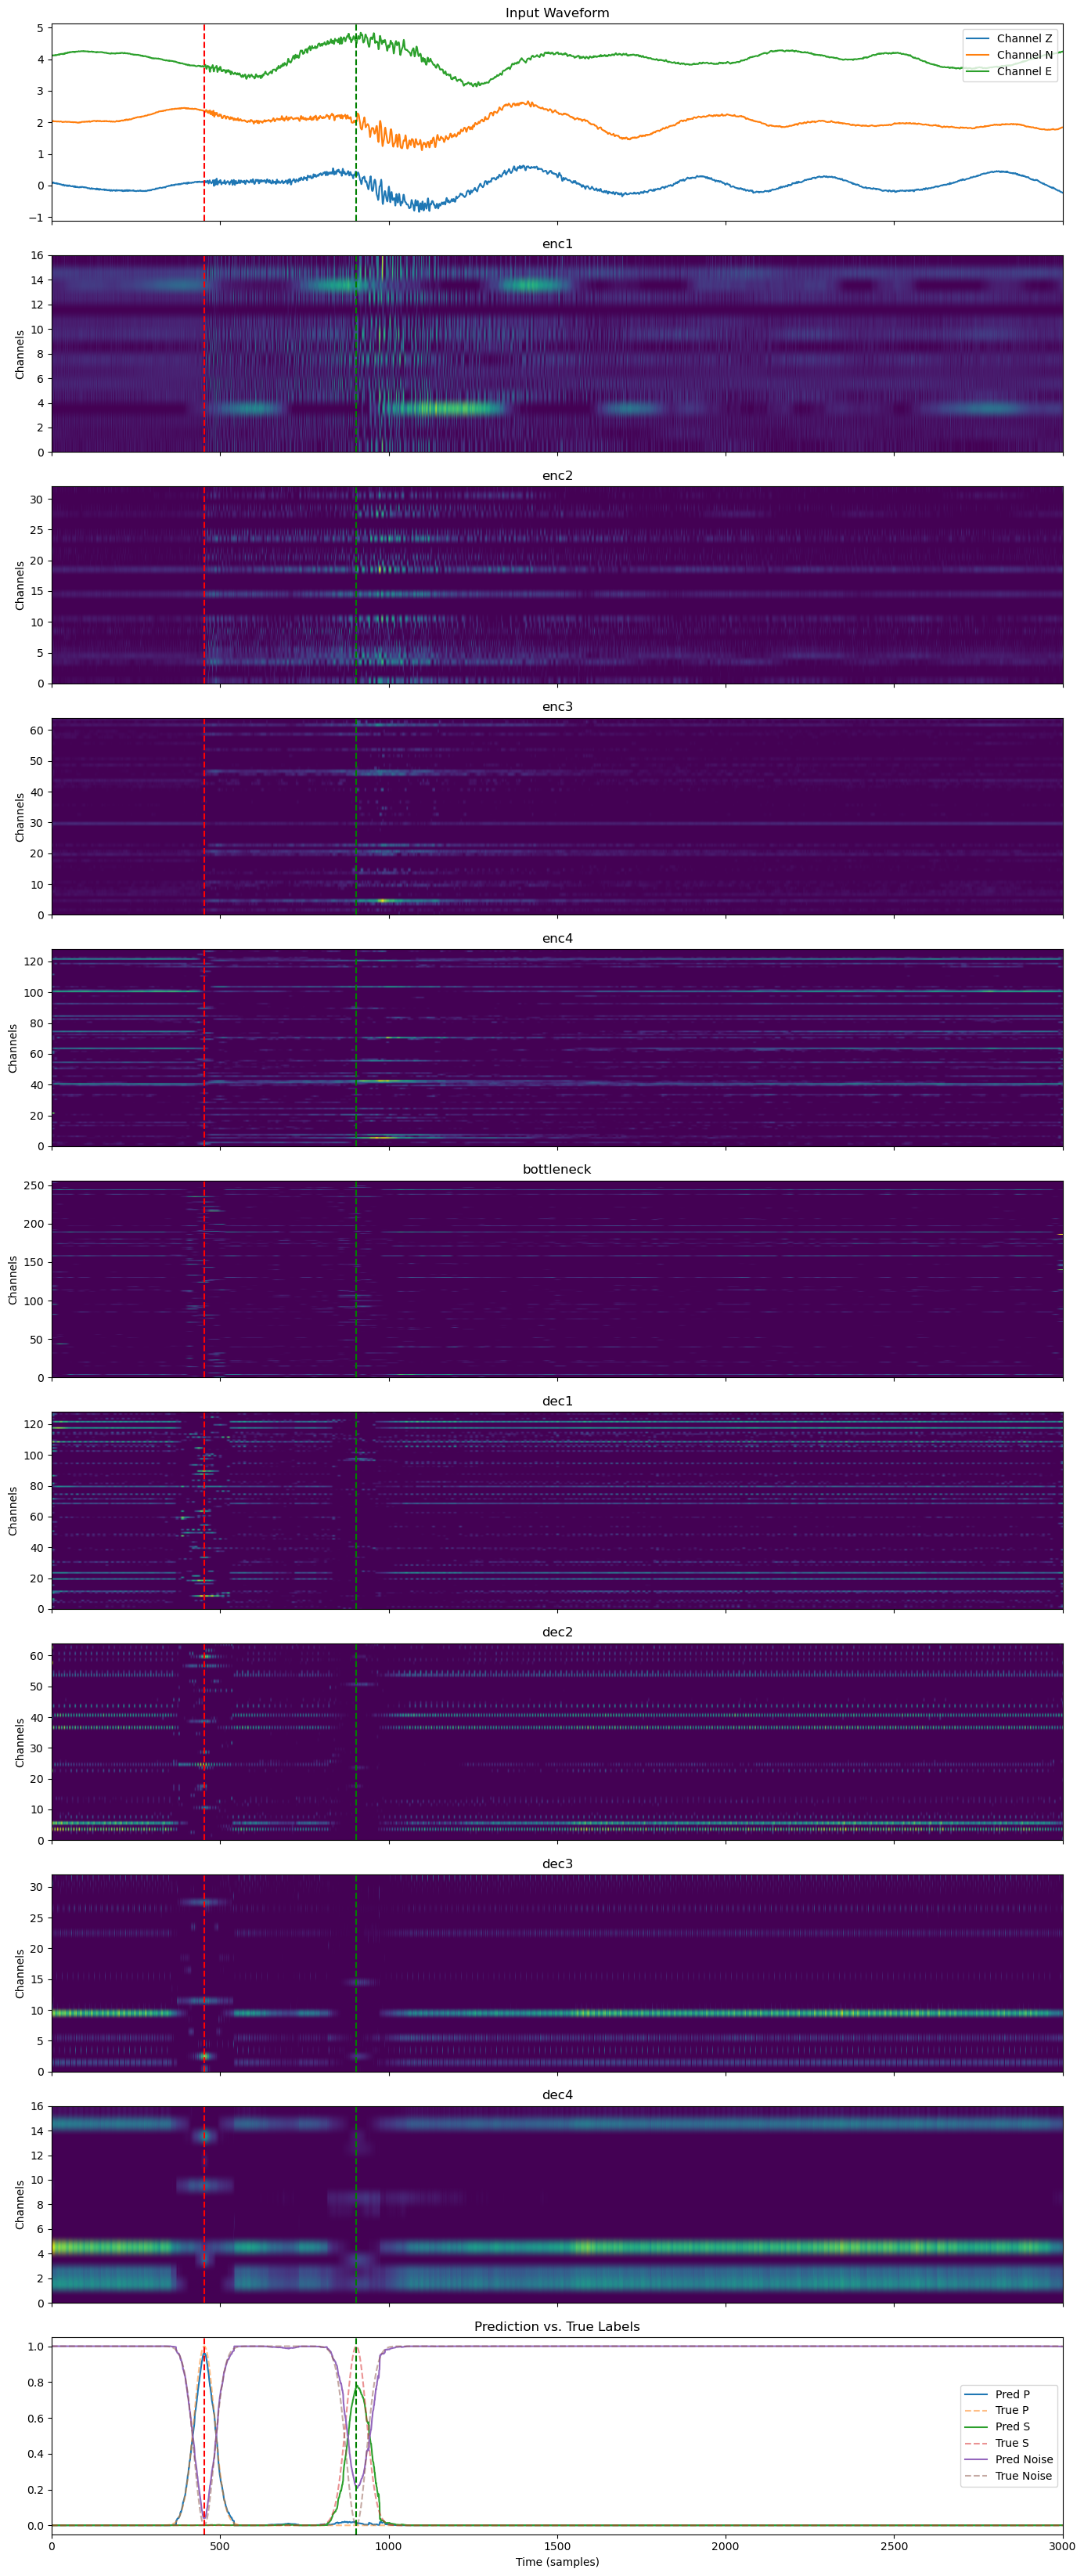

In [24]:
# --- 1. Slice a test window that includes P and S arrivals ---
start = 5000  # start index of the window
window_len = 3001
sample_id = 12
sample = test_generator[sample_id]
waveform = sample["X"][:, start:start+window_len]
true_labels = sample["y"][:, start:start+window_len]
meta = sample.get("meta", test.get_sample(sample_id)[1])  # get metadata

x = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).to(device)
features = model.forward_intermediate(x)

# --- 2. Extract input/prediction ---
input_wave = features["input"].squeeze().cpu().detach().numpy()
prediction = features["output"].squeeze().cpu().detach().numpy()

# --- 3. Collect intermediate layers (enc*, bottleneck, dec*) ---
layer_keys = [k for k in features.keys() if k.startswith("enc") or k == "bottleneck" or k.startswith("dec")]
layer_keys = sorted(layer_keys, key=lambda k: ("enc" not in k, "bottleneck" not in k, k))  # enc1, enc2, ..., bottleneck, dec1, ...

# --- 4. Create subplots ---
n_rows = 2 + len(layer_keys)  # input + all layers + output
fig, axes = plt.subplots(n_rows, 1, figsize=(14, 3 * n_rows), sharex=True)

# --- 5. Plot input waveform ---
for i in range(3):
    axes[0].plot(input_wave[i] + i * 2, label=f"Channel {['Z', 'N', 'E'][i]}")
axes[0].set_title("Input Waveform")
axes[0].legend()

# --- 6. Plot all intermediate layers with rescaled extent ---
for i, key in enumerate(layer_keys):
    fmap = features[key].squeeze().cpu().detach().numpy()
    extent = [0, input_wave.shape[-1], 0, fmap.shape[0]]
    axes[i+1].imshow(fmap, aspect="auto", cmap="viridis", extent=extent)
    axes[i+1].set_title(f"{key}")
    axes[i+1].set_ylabel("Channels")

# --- 7. Plot prediction vs. true labels ---
labels = ["P", "S", "Noise"]
for i in range(3):
    axes[-1].plot(prediction[i], label=f"Pred {labels[i]}", linestyle='-')
    axes[-1].plot(true_labels[i], label=f"True {labels[i]}", linestyle='--', alpha=0.5)
axes[-1].set_title("Prediction vs. True Labels")
axes[-1].legend()
axes[-1].set_xlabel("Time (samples)")

# --- 8. Add vertical P and S arrivals to all plots ---
p_arrival = meta.get("trace_P_arrival_sample")
s_arrival = meta.get("trace_S_arrival_sample")

if p_arrival is not None:
    p_shifted = p_arrival - start
    if 0 <= p_shifted < input_wave.shape[-1]:
        for ax in axes:
            ax.axvline(p_shifted, color="red", linestyle="--", label="P arrival")

if s_arrival is not None:
    s_shifted = s_arrival - start
    if 0 <= s_shifted < input_wave.shape[-1]:
        for ax in axes:
            ax.axvline(s_shifted, color="green", linestyle="--", label="S arrival")

plt.tight_layout()
plt.show()

## ✅ Conclusion

In this notebook, we implemented and visualized a U-Net model for seismic phase picking — a critical task in seismology for detecting P and S wave arrivals in continuous waveform data.

### 🧠 What We Did:
- Built a 1D U-Net architecture inspired by [PhaseNet](https://github.com/wayneweiqiang/PhaseNet), with skip connections and encoder-decoder structure.
- Visualized **intermediate activations** to better understand how features evolve through the network.
- Ran the model on real/test waveform windows and compared predicted probabilities with ground-truth labels.
- Highlighted arrival times and validated that the model captures key temporal features across channels.

### 📊 What We Learned:
- The U-Net is capable of localizing subtle waveform changes across multiple channels.
- Intermediate feature maps provide insight into what the network is learning at different stages (e.g., low-level vs. abstract features).
- Well-aligned predictions with arrival times demonstrate strong temporal sensitivity.

### 🧭 Next Steps:
- Move to the **Evaluation Notebook** where we:
  - Run the model over the full test set
  - Compute metrics like precision, and recall
  - Visualize confusion matrices and timing accuracy
- Try training the model from scratch on custom datasets (e.g., regional catalogs or GNSS-derived events).
- Add uncertainty estimation or ensemble techniques to improve robustness.

> 🚀 This model is a strong baseline for real-time or post-event seismic analysis — and we’re just getting started!
